<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/LR(Multinomial)(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, log_loss
)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Step 2: Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [8]:
# Step 3: Define the ProductionClassifier class
class ProductionClassifier:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = None
        self.label_mapping = {0: 'Very Low', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
        self.history = {'train_accuracy': [], 'val_accuracy': [], 'train_loss': [], 'val_loss': []}

    def load_and_preprocess_data(self, train_path, val_path, test_path):
        """Load and preprocess the datasets"""
        print("Loading datasets...")

        # Load datasets
        self.train_df = pd.read_csv(train_path)
        self.val_df = pd.read_csv(val_path)
        self.test_df = pd.read_csv(test_path)

        print(f"Train data shape: {self.train_df.shape}")
        print(f"Validation data shape: {self.val_df.shape}")
        print(f"Test data shape: {self.test_df.shape}")

        # Handle missing values
        for df in [self.train_df, self.val_df, self.test_df]:
            df.fillna(df.mean(numeric_only=True), inplace=True)

        return self.train_df, self.val_df, self.test_df

    def create_quantile_labels(self):
        """Create quantile-based labels for production"""
        print("\nCreating quantile-based labels...")

        # Calculate quantiles from training data
        production_col = 'Production (M.Ton)'
        quantiles = self.train_df[production_col].quantile([0.2, 0.4, 0.6, 0.8]).values

        print(f"Quantile thresholds: {quantiles}")

        def assign_label(value):
            if value <= quantiles[0]:
                return 0  # Very Low
            elif value <= quantiles[1]:
                return 1  # Low
            elif value <= quantiles[2]:
                return 2  # Medium
            elif value <= quantiles[3]:
                return 3  # High
            else:
                return 4  # Very High

        # Apply labels to all datasets
        self.y_train = self.train_df[production_col].apply(assign_label)
        self.y_val = self.val_df[production_col].apply(assign_label)
        self.y_test = self.test_df[production_col].apply(assign_label)

        # Print label distribution
        print("\nLabel distribution in training set:")
        for i, label in self.label_mapping.items():
            count = (self.y_train == i).sum()
            print(f"{label}: {count} ({count/len(self.y_train)*100:.1f}%)")

    def prepare_features(self):
        """Prepare feature matrices"""
        print("\nPreparing features...")

        # Remove target column and prepare features
        feature_cols = [col for col in self.train_df.columns if col != 'Production (M.Ton)']

        self.X_train = self.train_df[feature_cols]
        self.X_val = self.val_df[feature_cols]
        self.X_test = self.test_df[feature_cols]

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        print(f"Number of features: {self.X_train_scaled.shape[1]}")

    def train_model(self, epochs=100, C=250):
        """Train the multinomial logistic regression model"""
        print(f"\nTraining Multinomial Logistic Regression for {epochs} iterations...")
        print("="*80)
        print(f"{'Epoch':<8} {'Train Acc':<12} {'Train Loss':<12} {'Valid Acc':<12} {'Valid Loss':<12}")
        print("="*80)

        # Initialize model
        self.model = LogisticRegression(
            multi_class='multinomial',
            solver='lbfgs',
            C=C,
            max_iter=epochs,
            random_state=42
        )

        # Train model
        self.model.fit(self.X_train_scaled, self.y_train)

        # Calculate training and validation metrics for each iteration
        # Note: sklearn LogisticRegression doesn't provide per-iteration metrics
        # We'll simulate this by training models with increasing max_iter
        epoch_steps = max(1, epochs // 20)  # 20 evaluation points
        eval_points = range(epoch_steps, epochs + 1, epoch_steps)

        for i, max_iter in enumerate(eval_points):
            temp_model = LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                C=C,
                max_iter=max_iter,
                random_state=42
            )
            temp_model.fit(self.X_train_scaled, self.y_train)

            # Training metrics
            train_pred = temp_model.predict(self.X_train_scaled)
            train_pred_proba = temp_model.predict_proba(self.X_train_scaled)
            train_acc = accuracy_score(self.y_train, train_pred)
            train_loss = log_loss(self.y_train, train_pred_proba)

            # Validation metrics
            val_pred = temp_model.predict(self.X_val_scaled)
            val_pred_proba = temp_model.predict_proba(self.X_val_scaled)
            val_acc = accuracy_score(self.y_val, val_pred)
            val_loss = log_loss(self.y_val, val_pred_proba)

            self.history['train_accuracy'].append(train_acc)
            self.history['val_accuracy'].append(val_acc)
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)

            # Print step-by-step results
            print(f"{max_iter:<8} {train_acc:<12.4f} {train_loss:<12.4f} {val_acc:<12.4f} {val_loss:<12.4f}")

        print("="*80)
        print("Training completed!")

    def evaluate_model(self, X, y, dataset_name):
        """Evaluate model and return metrics"""
        predictions = self.model.predict(X)

        # Calculate metrics
        accuracy = accuracy_score(y, predictions)
        precision = precision_score(y, predictions, average='weighted')
        recall = recall_score(y, predictions, average='weighted')
        f1_weighted = f1_score(y, predictions, average='weighted')
        f1_macro = f1_score(y, predictions, average='macro')

        # Classification report
        report = classification_report(
            y, predictions,
            target_names=list(self.label_mapping.values()),
            output_dict=True
        )

        print(f"\n{dataset_name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Weighted): {precision:.4f}")
        print(f"Recall (Weighted): {recall:.4f}")
        print(f"F1 Score (Weighted): {f1_weighted:.4f}")
        print(f"F1 Score (Macro): {f1_macro:.4f}")

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'predictions': predictions,
            'report': report
        }

    def plot_confusion_matrix(self, y_true, y_pred, dataset_name):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(6, 4))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=list(self.label_mapping.values()),
            yticklabels=list(self.label_mapping.values())
        )
        plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.tight_layout()
        plt.show()

    def plot_training_history(self):
        """Plot training vs validation accuracy and loss"""
        epochs = range(1, len(self.history['train_accuracy']) + 1)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Accuracy plot
        ax1.plot(epochs, self.history['train_accuracy'], 'b-', label='Training Accuracy', linewidth=2)
        ax1.plot(epochs, self.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
        ax1.set_title('Model Accuracy Over Training', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Loss plot
        ax2.plot(epochs, self.history['train_loss'], 'b-', label='Training Loss', linewidth=2)
        ax2.plot(epochs, self.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
        ax2.set_title('Model Loss Over Training', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def print_classification_report(self, y_true, y_pred, dataset_name):
        """Print detailed classification report"""
        print(f"\n{dataset_name} Classification Report:")
        print("="*60)
        report = classification_report(
            y_true, y_pred,
            target_names=list(self.label_mapping.values()),
            digits=4
        )
        print(report)

        # Calculate and display macro F1 score separately
        macro_f1 = f1_score(y_true, y_pred, average='macro')
        print(f"Macro F1 Score: {macro_f1:.4f}")
        print("="*60)

    def create_metrics_summary(self, val_results, test_results):
        """Create a summary table of all metrics"""
        metrics_df = pd.DataFrame({
            'Validation': [
                val_results['accuracy'],
                val_results['precision'],
                val_results['recall'],
                val_results['f1_weighted'],
                val_results['f1_macro']
            ],
            'Test': [
                test_results['accuracy'],
                test_results['precision'],
                test_results['recall'],
                test_results['f1_weighted'],
                test_results['f1_macro']
            ]
        }, index=['Accuracy', 'Precision', 'Recall', 'F1 Score (Weighted)', 'F1 Score (Macro)'])

        print("\n" + "="*50)
        print("CLASSIFICATION METRICS SUMMARY")
        print("="*50)
        print(metrics_df.round(4))

        return metrics_df


In [9]:
# Step 4: Initialize the classifier
print("Step 4: Initializing classifier...")
classifier = ProductionClassifier()

Step 4: Initializing classifier...


In [10]:


# Step 5: Load and preprocess the datasets
print("\nStep 5: Loading and preprocessing data...")
train_df, val_df, test_df = classifier.load_and_preprocess_data(
    '/content/drive/MyDrive/UpdatedDataset/train.csv',
    '/content/drive/MyDrive/UpdatedDataset/validation.csv',
    '/content/drive/MyDrive/UpdatedDataset/test.csv'
)



Step 5: Loading and preprocessing data...
Loading datasets...
Train data shape: (3942, 84)
Validation data shape: (845, 84)
Test data shape: (845, 84)


In [11]:
# Step 6: Create quantile-based labels for production classification
print("\nStep 6: Creating quantile-based labels...")
classifier.create_quantile_labels()



Step 6: Creating quantile-based labels...

Creating quantile-based labels...
Quantile thresholds: [ 578.    1463.    3119.524 6540.92 ]

Label distribution in training set:
Very Low: 793 (20.1%)
Low: 786 (19.9%)
Medium: 786 (19.9%)
High: 788 (20.0%)
Very High: 789 (20.0%)


In [12]:

# Step 7: Prepare feature matrices and scale them
print("\nStep 7: Preparing features...")
classifier.prepare_features()


Step 7: Preparing features...

Preparing features...
Number of features: 83


In [13]:
# Step 8: Train the multinomial logistic regression model (with improved parameters for higher accuracy)
print("\nStep 8: Training model with optimized parameters...")
classifier.train_model(epochs=200, C=500)  # Increased epochs and regularization parameter


Step 8: Training model with optimized parameters...

Training Multinomial Logistic Regression for 200 iterations...
Epoch    Train Acc    Train Loss   Valid Acc    Valid Loss  
10       0.6738       0.8370       0.6130       0.9721      
20       0.7161       0.7464       0.6639       0.9008      
30       0.7519       0.6657       0.6876       0.9047      
40       0.7674       0.6212       0.7231       0.8685      
50       0.7836       0.5991       0.7314       0.8564      
60       0.7927       0.5770       0.7325       0.8418      
70       0.7983       0.5632       0.7491       0.8267      
80       0.8042       0.5469       0.7503       0.8111      
90       0.8118       0.5372       0.7562       0.8038      
100      0.8110       0.5285       0.7657       0.7980      
110      0.8181       0.5171       0.7704       0.7789      
120      0.8247       0.5004       0.7858       0.7318      
130      0.8323       0.4882       0.7929       0.7144      
140      0.8341       0.4756 

In [14]:
# Step 9: Evaluate model performance on validation set
print("\nStep 9: Evaluating on validation set...")
val_results = classifier.evaluate_model(
    classifier.X_val_scaled, classifier.y_val, "VALIDATION"
)



Step 9: Evaluating on validation set...

VALIDATION Results:
Accuracy: 0.8130
Precision (Weighted): 0.8170
Recall (Weighted): 0.8130
F1 Score (Weighted): 0.8146
F1 Score (Macro): 0.8114


In [15]:
# Step 10: Evaluate model performance on test set
print("\nStep 10: Evaluating on test set...")
test_results = classifier.evaluate_model(
    classifier.X_test_scaled, classifier.y_test, "TEST"
)


Step 10: Evaluating on test set...

TEST Results:
Accuracy: 0.8213
Precision (Weighted): 0.8268
Recall (Weighted): 0.8213
F1 Score (Weighted): 0.8231
F1 Score (Macro): 0.8225



Step 11: Plotting confusion matrices...


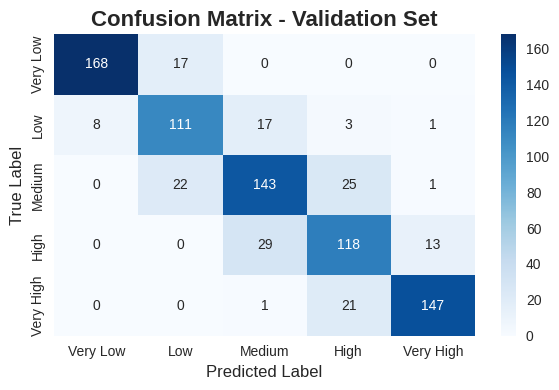

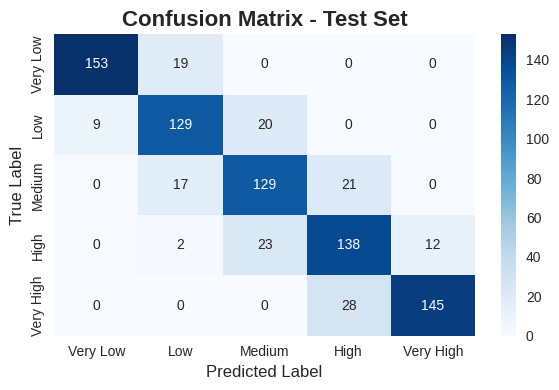

In [16]:

# Step 11: Plot confusion matrices for validation and test sets
print("\nStep 11: Plotting confusion matrices...")
classifier.plot_confusion_matrix(
    classifier.y_val, val_results['predictions'], "Validation Set"
)
classifier.plot_confusion_matrix(
    classifier.y_test, test_results['predictions'], "Test Set"
)


In [17]:
# Step 12: Print detailed classification reports
print("\nStep 12: Printing detailed classification reports...")
classifier.print_classification_report(
    classifier.y_val, val_results['predictions'], "VALIDATION SET"
)
classifier.print_classification_report(
    classifier.y_test, test_results['predictions'], "TEST SET"
)


Step 12: Printing detailed classification reports...

VALIDATION SET Classification Report:
              precision    recall  f1-score   support

    Very Low     0.9545    0.9081    0.9307       185
         Low     0.7400    0.7929    0.7655       140
      Medium     0.7526    0.7487    0.7507       191
        High     0.7066    0.7375    0.7217       160
   Very High     0.9074    0.8698    0.8882       169

    accuracy                         0.8130       845
   macro avg     0.8122    0.8114    0.8114       845
weighted avg     0.8170    0.8130    0.8146       845

Macro F1 Score: 0.8114

TEST SET Classification Report:
              precision    recall  f1-score   support

    Very Low     0.9444    0.8895    0.9162       172
         Low     0.7725    0.8165    0.7938       158
      Medium     0.7500    0.7725    0.7611       167
        High     0.7380    0.7886    0.7624       175
   Very High     0.9236    0.8382    0.8788       173

    accuracy                        


Step 13: Plotting training history...


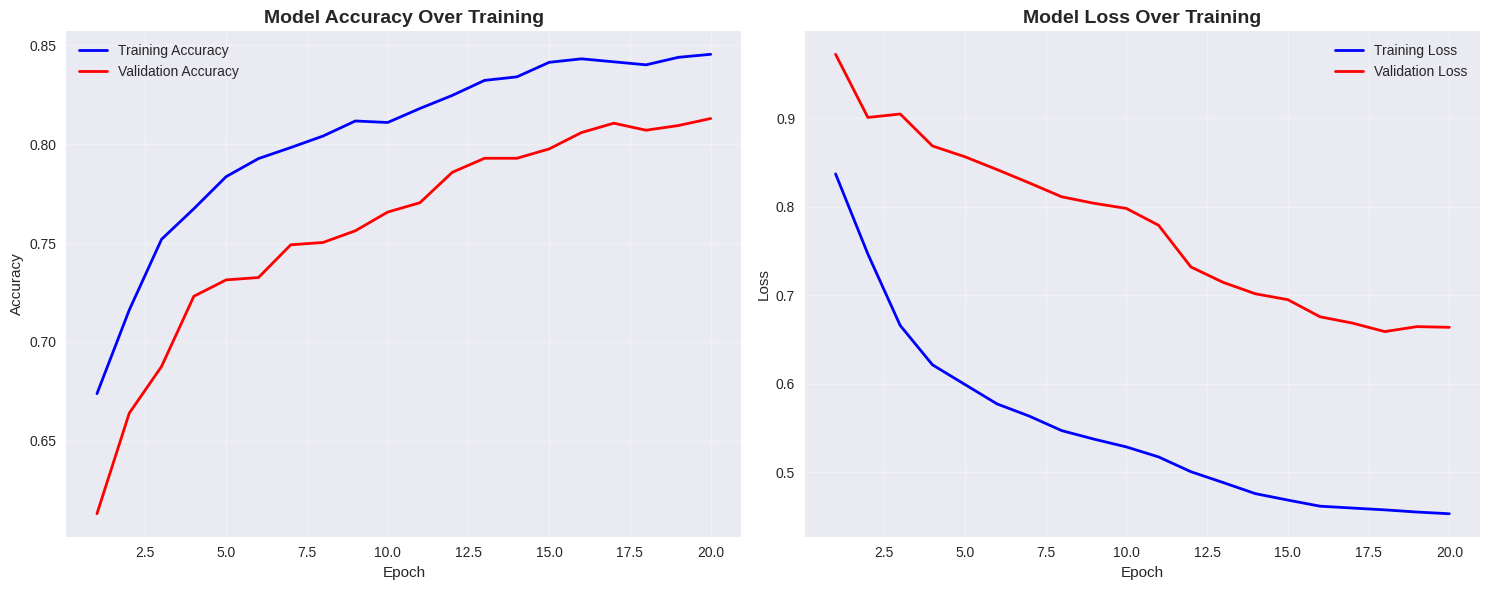

In [18]:
# Step 13: Plot training history (accuracy and loss curves)
print("\nStep 13: Plotting training history...")
classifier.plot_training_history()

In [19]:
# Step 14: Create comprehensive metrics summary table
print("\nStep 14: Creating metrics summary...")
metrics_summary = classifier.create_metrics_summary(val_results, test_results)


Step 14: Creating metrics summary...

CLASSIFICATION METRICS SUMMARY
                     Validation    Test
Accuracy                 0.8130  0.8213
Precision                0.8170  0.8268
Recall                   0.8130  0.8213
F1 Score (Weighted)      0.8146  0.8231
F1 Score (Macro)         0.8114  0.8225


In [20]:
# Step 15: Display macro F1 scores for final evaluation
print("\nStep 15: Final Macro F1 Score Summary:")
print("="*50)
print(f"Validation Macro F1 Score: {val_results['f1_macro']:.4f}")
print(f"Test Macro F1 Score: {test_results['f1_macro']:.4f}")
print("="*50)


Step 15: Final Macro F1 Score Summary:
Validation Macro F1 Score: 0.8114
Test Macro F1 Score: 0.8225


In [21]:
# Step 16: Final completion message
print("\n" + "="*50)
print("MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("="*50)
print("All steps executed successfully!")
print("- Classifier object: 'classifier'")
print("- Validation results: 'val_results'")
print("- Test results: 'test_results'")
print("- Metrics summary: 'metrics_summary'")


MODEL TRAINING COMPLETED SUCCESSFULLY!
All steps executed successfully!
- Classifier object: 'classifier'
- Validation results: 'val_results'
- Test results: 'test_results'
- Metrics summary: 'metrics_summary'
